In [6]:
"""
Script for plotting figures for a flow chart of processing methods

"""

#Define imports
from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from em_apex_processing import *
from spectral_processing import *
import os
import warnings


#########################
Cmax=100
uVpc = 1e6 * (10e-3 / (2**24))

Nfit=2
nstep_off=5
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 20 #
#Andy sets navg (spectrum time windowing) to 120
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-ctd.mat"
EFR = loadmat(fname)


efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)


ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)
#Pef = Pef-5

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)


fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];

#Do the 50s fits 
[e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

#Get overall fi and calculate the residuals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    e1off=np.nanmean(e1offs,1);
    e2off=np.nanmean(e2offs,1);
    e1fit=np.nanmean(e1fits,1);
    e2fit=np.nanmean(e2fits,1);

#Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to velocity (m/s)
e1r = e1r*sfv1
e2r = e2r*sfv2


#Now use the angles to rotate to x-y coordinates
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r
E_y = E2_r


#Now take the spectra
nblock = 120
fs = 1
[u_x, z_x] = reshape_u(E_x, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
#len(E_x.shape)
[u_y, z_y] = reshape_u(E_y, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)

 #Now try highpass filtering the data
sos = signal.butter(10, 0.03, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)
[u_x, z_x] = reshape_u(E_x_filtered, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
len(E_x.shape)
[u_y, z_y] = reshape_u(E_y_filtered, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = UUwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy

[Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, nblock, 10000, fs)

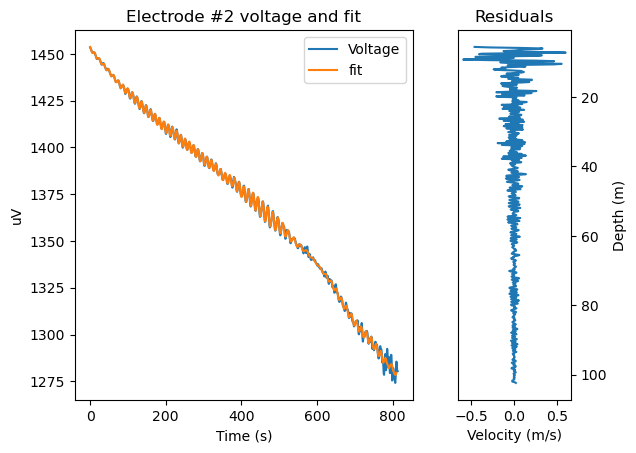

In [14]:


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
a0.plot(mlt_efr - mlt_efr[0], E2, label='Voltage')
a0.plot(mlt_efr - mlt_efr[0], e2fit, label='fit')
a0.legend()
a1.plot(e2r, Pef)
a1.yaxis.tick_right()
a1.set_ylabel("Depth (m)")
a1.set_xlabel("Velocity (m/s)")
a1.yaxis.set_label_position("right")
a1.invert_yaxis()




a0.set_xlabel("Time (s)")
a0.set_ylabel("uV")
a0.set_title("Electrode #2 voltage and fit")
a1.set_title("Residuals")

f.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/voltage_fit.png")

Text(0.5, 1.0, "Highpass filtered u' and v'")

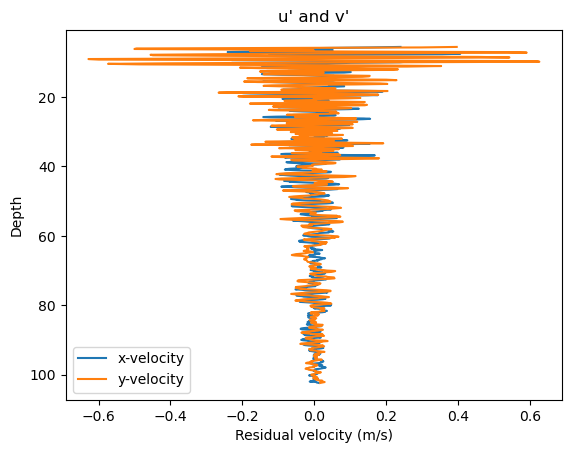

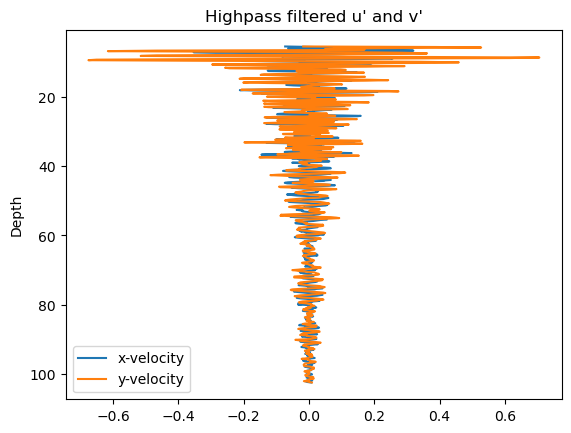

In [15]:
 #Now try highpass filtering the data
sos = signal.butter(10, 0.03, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)

plt.figure()
plt.plot(E_x, Pef, label="x-velocity")
plt.plot(E_y, Pef, label='y-velocity')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel("Depth")
plt.title("u' and v'")
plt.xlabel("Residual velocity (m/s)")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/x_y_residuals.png")

plt.figure()
plt.plot(E_x_filtered, Pef, label="x-velocity")
plt.plot(E_y_filtered, Pef, label='y-velocity')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel("Depth")
plt.title("Highpass filtered u' and v'")

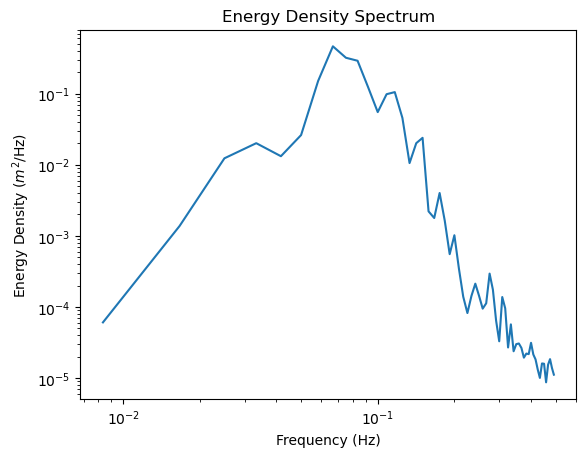

In [16]:
plt.figure()
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))
#plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'Energy Density ($m^2$/Hz)')
plt.title("Energy Density Spectrum")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/raw_spec.png")


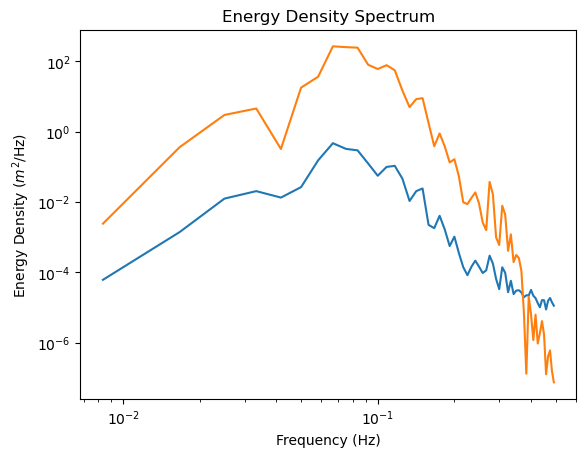

In [17]:
plt.figure()
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))
plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r'Energy Density ($m^2$/Hz)')
plt.title("Energy Density Spectrum")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/raw_spec_w_corr.png")



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_43871/985640395.py:19: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))


Text(0.5, 1.0, 'Energy Density Spectrum')

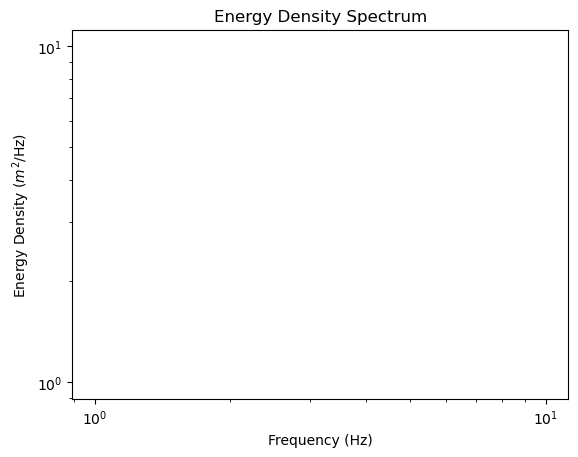

In [187]:
[u_x, z_x] = reshape_u(E_x_filtered, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
#len(E_x.shape)
[u_y, z_y] = reshape_u(E_y_filtered, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = UUwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy

plt.figure()
#plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
plt.loglog(fwindow[1:], np.nanmean(Eh, axis=0))

plt.xlabel("Frequency (Hz)")
plt.ylabel(r'Energy Density ($m^2$/Hz)')
plt.title("Energy Density Spectrum")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/raw_spec.png")



In [107]:
from scipy.io import netcdf

#Load CDIP Data
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
time = nc.variables['waveTime'][:]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]

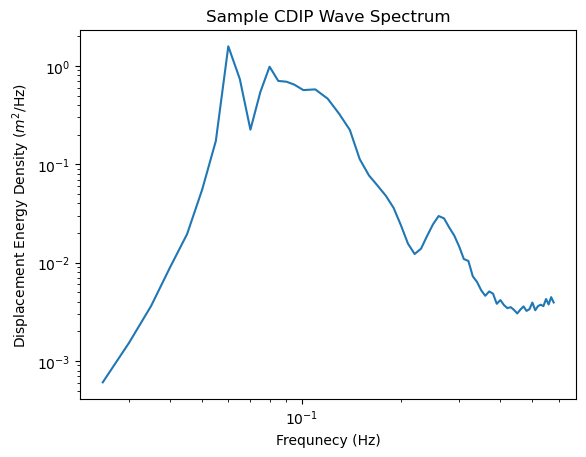

In [117]:
plt.loglog(wave_freq, np.nanmean(energy_density[100:110, :], axis=0))
plt.xlabel("Frequnecy (Hz)")
plt.ylabel(r"Displacement Energy Density ($m^2$/Hz)")
plt.title("Sample CDIP Wave Spectrum")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/sample_CDIP_spec.png")


In [130]:
EFR.keys()

dict_keys(['HZ', 'HX', 'HY', 'version', 'AGE', 'BT', 'runid', 'AXPP', 'ZRPP', 'OVERFLOW', 'UXT', 'HXPP', 'SEQNO', 'HYPP', 'PC', 'hpid', 'E1', 'E2', 'AZPP', 'AYPP', 'HZPP', 'AY', 'AX', 'AZ', 'typ', 'ZR', 'E2PP', 'BTPP', 'E1PP'])

In [131]:
CTD.keys()

dict_keys(['nobs', 'P', 'S', 'T', 'uxthdr', 'typ', 'UXT', 'ofile', 'pc', 'hpid', 'nbytes', 'which', 'runid'])

In [133]:
CTD['P']

array([[144.31054688, 142.16113281, 140.12109375, 137.62109375,
        135.140625  , 133.140625  , 131.15136719, 128.40136719,
        125.63085938, 123.01074219, 120.11132812, 117.17089844,
        114.40136719, 111.48144531, 108.84082031, 106.68066406,
        104.05078125, 101.29101562,  98.55078125,  95.73144531,
         93.17089844,  90.70117188,  87.98144531,  85.09082031,
         82.93066406,  80.17089844,  77.08105469,  74.09082031,
         71.12109375,  68.27050781,  65.44140625,  62.49121094,
         59.62109375,  57.16113281,  54.20117188,  51.03125   ,
         47.92089844,  44.77050781,  41.79101562,  39.18066406,
         37.01074219,  35.63085938,  34.23144531,  32.45117188,
         30.26074219,  27.94140625,  25.50097656,  22.83105469,
         20.31054688,  17.31054688,  13.95117188,  10.56054688,
          7.09082031,   4.4609375 ]])

In [134]:
Pef

array([102.37130166, 102.24333939, 102.11537714, 101.98741486,
       101.85945258, 101.7314903 , 101.60352805, 101.47556578,
       101.3476035 , 101.22014638, 101.09308971, 100.96603303,
       100.83897636, 100.71191972, 100.58486305, 100.45780638,
       100.33074974, 100.20369307, 100.07663639,  99.94957972,
        99.82252308,  99.69546641,  99.56840974,  99.4413531 ,
        99.31429643,  99.18723976,  99.06018308,  98.93312644,
        98.80606977,  98.6790131 ,  98.55195646,  98.4268971 ,
        98.30185639,  98.17681568,  98.051775  ,  97.92673429,
        97.80169357,  97.67665289,  97.55161218,  97.42657147,
        97.30153076,  97.17649008,  97.05144937,  96.92640866,
        96.80136797,  96.67632726,  96.55128655,  96.42624584,
        96.30120516,  96.17616445,  96.05112374,  95.92608305,
        95.80104234,  95.67880201,  95.56007692,  95.44135187,
        95.32262678,  95.20390169,  95.08517664,  94.96645155,
        94.84772646,  94.72900138,  94.61027632,  94.49

In [136]:
mlt_efr[-1]

1490929538.38865

In [138]:
ctd_time[-1]

1490929543.0

EFR['UXT']

In [140]:
EFR['UXT'][0, -1]

1490929539

In [142]:
EFR['AGE'][0, -1]

1.0

In [143]:
Pef[-1]

5.134676959106906

In [179]:
E2.shape

(798,)

In [180]:
e2fit.shape

(798,)

In [181]:
e2fit[-10:-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

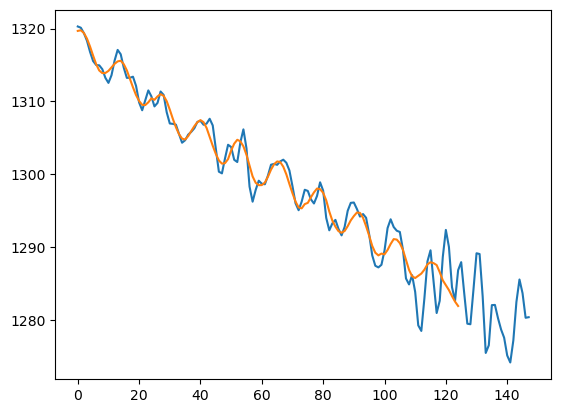

In [183]:
plt.plot(E2[650:])
plt.plot(e2fit[650:])